In [2]:
%matplotlib inline

from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np

# Hill-type muscle model

## Elements

The model consists of three elements:

- A contractile element (CE) that represents the muscle fibers that contract based on the muscle activation state.
- A serial elastic element (SEE) that represents the tendons that connect the muscle to the bones.
- A parallel elastic element (PEE) that represents the passive elastic material surrounding muscle fibers.

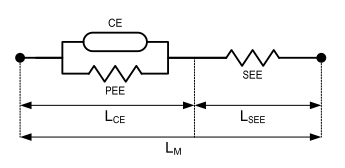

In [2]:
Image(filename='images/muscle_model.png')

## Forces

  - $F_{max}$: maximum isometrical force. optimized constant.
  - $F_{CE}$: contractile element force. calculated. $\eqref{1}$
  - $F_{SEE}$: parallel element force. calculated. $\eqref{2}$
  - $F_{PEE}$: parallel element force. $\eqref{3}$
  - $F_M$: total muscle force. calculated. $\eqref{4}$

### Force relationships

$$ \begin{align}
  \tag{4}
  \label{4}
  F_M &= F_{CE} + F_{PEE} = F_{SEE}
\end{align} $$

### Contractile element

From Wang et al. 2012 and confirmed by author:

$$ L_{CE}^{norm} = \frac{L_{CE}}{L_{CE}^{opt}} $$

$$ V_{CE}^{norm} = \frac{V_{CE}}{L_{CE}^{opt}} $$

#### Force-length relationship [Geyer et al. 2003]

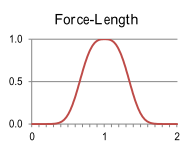

In [3]:
Image(filename='images/force_length.png')

$$ \begin{equation}
f_L(L_{CE}^{norm}) =
  \exp \left[ c \left|\frac{L_{CE}^{norm} - L_{CE}^{opt}}{L_{CE}^{opt} w}\right|^3 \right]
\end{equation} $$

- $L_{CE}^{opt}$: optimum CE length (for maximum force production).
- $w$: width of the bell-shaped $f_L(L_{CE}^{norm})$ curve.
- $c$: $ln(0.05)$ fulfilling $f_L\left(L_{CE}^{opt}\left(1 \pm w\right)\right)$

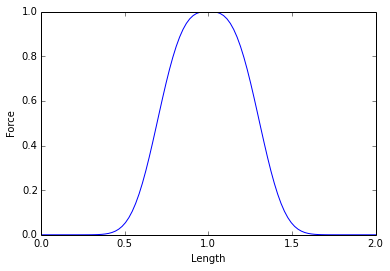

In [44]:
c = np.log(0.05)
L_CE_opt = 1.0
w = 0.5

def f_L(L_CE_norm):
    return np.exp(c * np.power(np.absolute((L_CE_norm - L_CE_opt) / (L_CE_opt * w)), 3.0))
f_L = np.vectorize(f_L)

L_CE_norm = np.linspace(0, 2, 100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Length')
ax.set_ylabel('Force')
ax.plot(L_CE_norm, f_L(L_CE_norm))

#### Force-velocity relationship [Geyer et al. 2003]

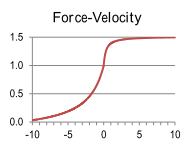

In [26]:
Image(filename='images/force_velocity.png')

$$ f_V\left(V_{CE}^{norm}\right) = \begin{cases}
  \frac{V_{max} - V_{CE}^{norm}}{V_{max} + K V_{CE}^{norm}} & \text{if $V_{CE}^{norm} < 0$} \\
  N + (N - 1) \frac{V_{max} + V_{CE}^{norm}}{7.56 K V_{CE}^{norm} - V_{max}} & \text{if $V_{CE}^{norm} \geq 0$}
\end{cases} $$

- $V_{CE} < 0$ follows the Hill equation (Hill 1938) for muscle shortening where $V_{max} < 0$ is the maximum contraction velocity.
- $V_{CE} \geq 0$ muscle lengthing is characterized by an equation based on Aubert (1956).

- $V_{max} = -12 l_{opt}s^{-1}$: maximum shortening velocity
- $K$: curvature constant.
- $N$: dimensionless amount of force $\frac{F_M}{F_{max}}$ reached at a lengthening velocity $V_{CE} = -V_{max}$.

Relationship (cannot compute directly for $V_{CE}$ because its recursive):

$$ \begin{equation}
f_V\left(V_{CE}^{norm}\right) = \frac{F_{SEE} - F_{PEE}}{a F_{max} f_L(L_{CE}^{norm})}
\end{equation} $$

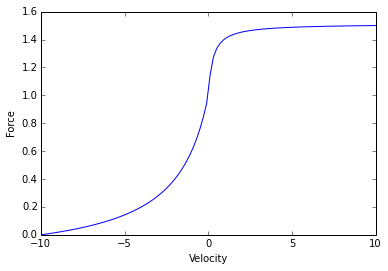

In [4]:
V_max = -10.0
K = 5.0
N = 1.5

def f_V(V_CE_norm): 
  if V_CE_norm < 0:
    return (V_max - V_CE_norm) / (V_max + (K * V_CE_norm))
  else:
    return N + (N - 1) * ((V_max + V_CE_norm) / ((7.56 * K * V_CE_norm) - V_max))
f_V = np.vectorize(f_V)

V_CE_norm = np.linspace(-10, 10, 100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Velocity')
ax.set_ylabel('Force')
ax.plot(V_CE_norm, f_V(V_CE_norm))

#### Force-velocity inverse

$$ f_V^{-1} \left(y\right) = \begin{cases}
  \frac{V_{max} \left(1 - y\right)}{1 + y K} & \text{if $y < 1$} \\
  \frac{V_{max} \left(y - 1\right)}{7.56 K \left(y - N\right) - N + 1} & \text{if $y \geq 1$}
\end{cases} $$

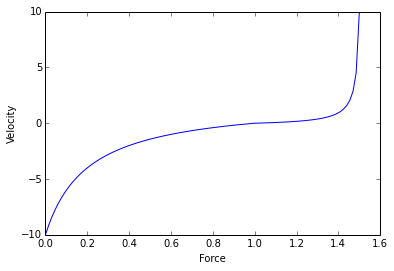

In [6]:
def f_V_inv(y):
  if y < 1:
    return (V_max * (1 - y)) / (1 + (y * K))
  else:
    return (V_max * (y - 1)) / ((7.56 * K * (y - N)) - N + 1)
f_V_inv = np.vectorize(f_V_inv)

y = np.linspace(0, 1.5, 100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Force')
ax.set_ylabel('Velocity')
ax.plot(y, f_V_inv(y))

#### Contractile-element velocity

$V_{CE}$ is the result of equation $\eqref{6}$ and derived from Equations $\eqref{1}$ and $\eqref{4}$, by inverting the force-velocity relation $f_V$:

$$\begin{align}
  \label{6}
  \tag{6}
  V_{CE} &= f_v^{-1} \left[\frac{F_{SEE} - F_{PEE}}{a F_{max} f_L(L_{CE}^{norm})}\right] \\
  &= f_v^{-1} \left[\frac{F_{CE}}{\frac{F_{CE}}{f_V(V_{CE}^{norm})}}\right] \\
  &= f_v^{-1} \left[f_V(V_{CE}^{norm})\right]
\end{align}$$

Because the following relationship is true:

$$ \frac{x}{\frac{x}{y}} = y $$

Thus:

$$ \frac{F_{CE}}{\frac{F_{CE}}{f_V(V_{CE})}} = f_V(V_{CE}) $$

As well as this inverse function relationship (http://en.wikipedia.org/wiki/Inverse_function):

$$ x = f^{-1}(f(x)) = f(f^{-1}(x)) $$

Thus:

$$ V_{CE} = f_V^{-1}(f_V(V_{CE})) = f_V(f_V^{-1}(V_{CE})) $$

#### Contractile-element force

$$\begin{align}
  \label{1}
  \tag{1}
  F_{CE}& = a F_{max} f_L(L_{CE}^{norm}) f_V(V_{CE}^{norm}) \\
  \frac{F_{CE}}{f_V(V_{CE}^{norm})}& = a F_{max} f_L(L_{CE}^{norm})
\end{align}$$

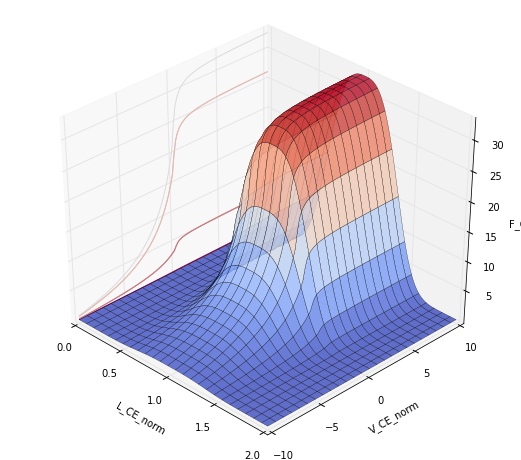

In [6]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

F_max = 22.0
a = 1.0

def f_CE(L_CE_norm, V_CE_norm): 
  return a * F_max * f_L(L_CE_norm) * f_V(V_CE_norm)

L_CE_norm = np.linspace(0, 2, 100)
V_CE_norm = np.linspace(-10, 10, 100)
L_CE_norm, V_CE_norm = np.meshgrid(L_CE_norm, V_CE_norm)

f_CE = np.vectorize(f_CE)
F_CE = f_CE(L_CE_norm, V_CE_norm)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(L_CE_norm, V_CE_norm, F_CE, rstride=4, cstride=4, alpha=0.8, linewidth=0.25, cmap=cm.coolwarm)

cset = ax.contour(L_CE_norm, V_CE_norm, F_CE, zdir='x', offset=0, cmap=cm.coolwarm)

ax.view_init(35, -45)

ax.set_xlabel('L_CE_norm')
ax.set_ylabel('V_CE_norm')
ax.set_zlabel('F_CE')

### Serial element

The passive forces produced by the elastic elements, $F_{PEE}$ and $F_{SEE}$ are modeled as non-linear springs based on their lengths:

\begin{align}
  \label{2}
  \tag{2}
  F_{SEE} & = f_{SEE}(L_M - L_{CE}) \\
          & = f_{SEE}(L_{SEE})
\end{align}

$f_{SEE}$ is described in Geyer et al. 2003:

$$ f_{SEE} = \begin{cases}
  \left(\frac{\epsilon}{\epsilon_{ref}}\right)^2 & \text{if $\epsilon > 0$} \\
  0 & \text{if $\epsilon \leq 0$}
\end{cases} $$

- $\epsilon$: tendon strain. $\epsilon = \frac{L_{SEE} - L_{SEE}^{rest}}{L_{SEE}^{rest}}$
- $L_{SEE}^{rest}$: tendon's resting length
- $\epsilon_{ref}$: tendon reference strain with $f_{SEE}\left(\epsilon_{ref}\right) = 1$

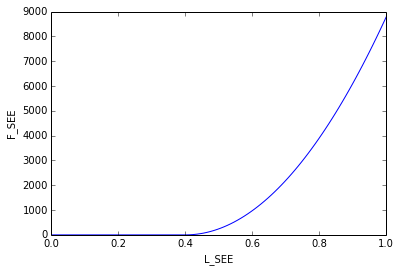

In [8]:
L_SEE_rest = 0.4
epsilon_ref = 0.04 * L_SEE_rest

def f_SEE(L_SEE):
    epsilon = (L_SEE - L_SEE_rest) / L_SEE_rest
    if epsilon > 0.0:
        return (epsilon / epsilon_ref)**2.0
    else:
        return 0.0

L_SEE = np.linspace(0, 1, 100)

f_SEE = np.vectorize(f_SEE)
F_SEE = f_SEE(L_SEE)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('L_SEE')
ax.set_ylabel('F_SEE')
ax.plot(L_SEE, F_SEE)

### Parallel element

\begin{equation}
  \label{3}
  \tag{3}
  F_{PEE} = f_{PEE}(L_{CE}^{norm})
\end{equation}

$f_{PEE}$ isn't described in Geyer et al. 2003 but is described in Geyer et al. 2010:

\begin{equation}
  f_{PEE} = F_{max} \left(\frac{L_{CE}^{norm} - L_{CE}^{opt}}{L_{CE}^{opt}\epsilon_{PE}}\right)^2 f_V\left(V_{CE}^{norm}\right)
\end{equation}

$\epsilon_{PE}$ = $w$ according to Geyer et al. 2010

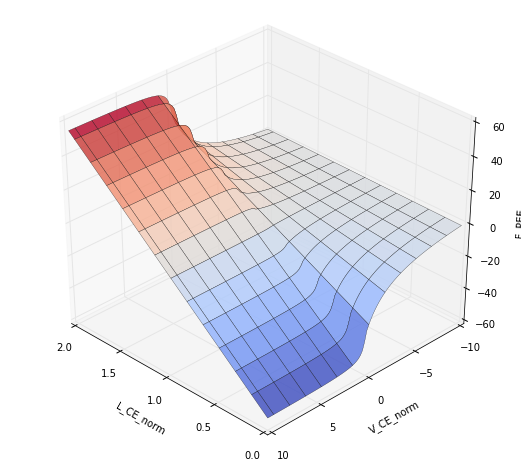

In [15]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

w = 0.6
V_max = -12.0
K = 5.0
N = 1.5

def f_PEE(L_CE_norm, V_CE_norm): 
  return F_max * ((L_CE_norm - L_CE_opt) / (L_CE_opt * w)) * f_V(V_CE_norm)

L_CE_norm = np.linspace(0, 2, 100)
V_CE_norm = np.linspace(-10, 10, 100)
L_CE_norm, V_CE_norm = np.meshgrid(L_CE_norm, V_CE_norm)

f_PEE = np.vectorize(f_PEE)
F_PEE = f_PEE(L_CE_norm, V_CE_norm)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(L_CE_norm, V_CE_norm, F_PEE, rstride=8, cstride=8, alpha=0.8, linewidth=0.25, cmap=cm.coolwarm)

ax.view_init(35, 135)

ax.set_xlabel('L_CE_norm')
ax.set_ylabel('V_CE_norm')
ax.set_zlabel('F_PEE')

## Lengths

- $L_M$: total muscle length $\eqref{8}$
- $L_{CE}$: contractile element length. initialized to $L_{CE}^{opt}$ then integrated from $V_{CE}$.
- $L_{SEE}$: serialize element length. derived from relationship.
- $L_{PEE}$: parallel element length. unused.
- $L_M^{rest}$: muscle rest length. derived from relationship.
- $L_{SEE}^{slack}$: tendon slack length. optimized param.
- $L_{CE}^{opt}$: optimal contractile element length. optimized param.

$$ \begin{equation}
  L_M = L_{SEE} + L_{CE}
\end{equation} $$

\begin{equation}
  \label{5}
  \tag{5}
  L_M^{rest} = L_{SEE}^{slack} + L_{CE}^{opt}
\end{equation}

$$\begin{equation}
  \label{8}
  \tag{8}
  L_M = \sum_{i=1}^{n-1} ||s_i||
\end{equation}$$

Muscle segment length:

$$ s_i = P_{i+1}^W - P_i^W $$

#### Contractile element length

The muscle state parameter $L_{CE}$ is then updated (each time step) through integration of the contraction velocity $V_{CE}$.

Be sure to use the velocity, then update it for Euler integration.

\begin{equation}
  \tag{6}
  L_{CE} = \int V_{CE} dt
\end{equation}

\begin{equation} L_{CE} = L_{CE} + V_{CE} dt \end{equation}

## Activation

- $a$: muscle activation
- $u$: neural activation signal:
- $c_a$: constant activation and deactivation rate. Default: $c_a = 100s^{-1}$ or 0.01.

\begin{equation}
  \label{7}
  \tag{7}
  \frac{\partial a}{\partial t} = c_a (u - a)
\end{equation}

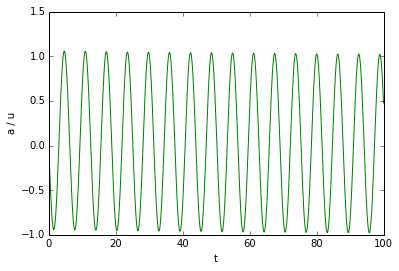

In [20]:
c_a = 0.01

def da(u, a): 
  return c_a * (u - a)

t_series = np.linspace(0, 100, 1000)
u_series = np.sin(t_series - (np.pi / 2)) * 100

a_series = []
a = 0.0

prev_t = 0
for (t, u) in zip(t_series, u_series):
    dt = t - prev_t
    a += da(u, a) * dt
    prev_t = t
    a_series.append(a)


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t_series, a_series, "g") # activation
# ax.plot(t_series, u_series, "b") # neural input
ax.set_xlabel('t')
ax.set_ylabel('a / u')

## Force application

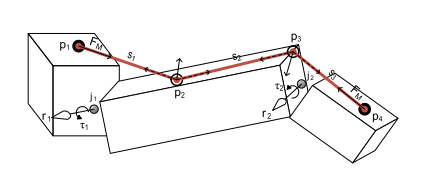

In [16]:
Image(filename='images/force_application.png')

The total muscle length $L_M$ with activation state $a$ to compute the scalar muscle contraction force $F_M$.

- $k$: a joint spanned by the muscle.
- $\tau_k$: the torque generated in the direction of the moment arm $r_k$.
- $r_k$: moment arm corresponding to the cross-product between the direction of the segment that crosses the joint $s_c$ and a vector from the joint center $j_k$ to any point on the segment $s_c$, such as $P_c^W$.
- $s_c$: muscle segment
- $j_k$: joint center

$$\begin{equation}
  \label{9}
  \tag{9}
  \tau_{k} = F_M ||r_k|| \\
  r_k = (P_{i+1}^W - P_i^W) \times \frac{s_c}{||s_c||}
\end{equation}$$

### Force relationships

- Torque (http://en.wikipedia.org/wiki/Torque): $ T = \frac{\partial L}{\partial t} $
- Net torque: $ T_{net} = I * a $
- Moment of inertia (http://en.wikipedia.org/wiki/Moment_of_inertia): $ I = \frac{L}{w} $
- Angular momentum: $ L = I * w $
- Force (http://en.wikipedia.org/wiki/Force): $ F = m * a $
- Angular acceleration (http://en.wikipedia.org/wiki/Angular_acceleration): $ a = \frac{T}{I} $